# Introduction


We will try to solve the problem of Image Recognition for a particular dataset. We will use pre-trained Network's architectures to complete this task. We will fine-tune our network properly , based on our dataset , in order to improve its efficiency and accuracy.
> 
We get two datasets with random objects from the www.vision.caltech.edu. We hold only the categories/classes that have more than 100 images for its class. In addition to that we do not want our class to have more than 200 images. This way we manage to have a balanced dataset , since every class will have almost the same number of datapoints. The task of object recognition is not a hard one. Therefore , we added a lot of different classes in order to increase the complexity of our dataset and of our task. Some classes are closely-related , so the distintion between this two classes will be a bit more challenging for our model .
>
For our task we will use VGG and SqueezeNet pretrained models. Both models are well suitable for image recognition, and have been pretrained in a big range of images classes. Therefore we will fine tune them , and test them on our dataset. In the end we will compare these two models and a baseline model, to see their efficiency, their advantages and disadvantages.

# Getting the Data


In [2]:
!wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
local_file = "101_ObjectCategories.tar.gz"

--2020-03-09 16:19:11--  http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131740031 (126M) [application/x-tar]
Saving to: ‘101_ObjectCategories.tar.gz’

101_ObjectCategorie 100%[===================>] 125.64M  27.5MB/s    in 4.6s    

2020-03-09 16:19:15 (27.4 MB/s) - ‘101_ObjectCategories.tar.gz’ saved [131740031/131740031]



In [24]:
!wget http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar

--2020-03-09 16:22:35--  http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1183006720 (1.1G) [application/x-tar]
Saving to: ‘256_ObjectCategories.tar’

256_ObjectCategorie 100%[===================>]   1.10G  35.9MB/s    in 37s     

2020-03-09 16:23:13 (30.2 MB/s) - ‘256_ObjectCategories.tar’ saved [1183006720/1183006720]



In [0]:
!tar -xf "101_ObjectCategories.tar.gz"

In [0]:
!tar -xf "256_ObjectCategories.tar"

In [0]:

import os
import shutil   
class_names = os.listdir("./101_ObjectCategories")
ok_class_names = []
for class_name in class_names:
  x = os.listdir("./101_ObjectCategories/"+class_name)
  if len(x)>100 and len(x)<200:
    ok_class_names.append(class_name)
  else:
    shutil.rmtree("./101_ObjectCategories/"+class_name)

In [0]:
from pprint import pprint
class_names = os.listdir("./256_ObjectCategories")
for class_name in class_names:
  x = os.listdir("./256_ObjectCategories/"+class_name)
  if len(x)>100 and len(x)<200:
    splits = class_name.split(".")
    ok_class_names.append(splits[1])
  else:
    shutil.rmtree("./256_ObjectCategories/"+class_name)
num_classes = len(ok_class_names)



Here we can see the list of the objects, that our model will be trained to classify.


In [51]:
print(ok_class_names)


['chandelier', 'bonsai', 'car_side', 'ketch', 'spoon', 'bulldozer', 'tweezer', 'laptop-101', 'knife', 'baseball-bat', 'leopards-101', 'screwdriver', 'cactus', 'snake', 'computer-monitor', 'head-phones', 'bat', 'octopus', 'diamond-ring', 'canoe', 'cartman', 'rifle', 'breadmaker', 'owl', 'cormorant', 'boxing-glove', 'photocopier', 'electric-guitar-101', 'elephant-101', 'tennis-court', 'ketch-101', 'dolphin-101', 'tomato', 'mars', 'ibis-101', 'kayak', 'hummingbird', 'syringe', 'penguin', 'snowmobile', 'microscope', 'spider', 'pci-card', 'elk', 'porcupine', 'car-side-101', 'iguana', 'tripod', 'backpack', 'rainbow', 'dog', 'grasshopper', 'socks', 'cannon', 'saddle', 'mattress', 'joy-stick', 'swiss-army-knife', 'dumb-bell', 'cockroach', 'bowling-pin', 'skateboard', 'light-house', 'soccer-ball', 'cake', 'swan', 'bowling-ball', 'necktie', 'treadmill', 'toad', 'touring-bike', 'teddy-bear', 'tennis-shoes', 'fern', 'ostrich', 'butterfly', 'camel', 'chimp', 'teapot', 'fire-truck', 'spaghetti', 'gu

Spliting the data folders properly, in order to load them to our models.

In [29]:
!pip install split-folders


  We split the folders  to train, validation and test. This way our Dataloader will be able to load the data with their labels to our our train , validation and test dataset accordingly.

In [48]:
import split_folders

split_folders.ratio("101_ObjectCategories", output="output", seed=1337, ratio=(.7, .2, .1)) # default values
split_folders.ratio("256_ObjectCategories", output="output", seed=1337, ratio=(.7, .2, .1)) # default values


Copying files: 472 files [00:00, 6606.75 files/s]
Copying files: 13094 files [00:02, 5255.61 files/s]


# VGG Model


In [52]:
import torchvision.models as models
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
data_dir = "./output/"
model_name = "vgg"

# Batch size for training (change depending on how much memory you have)
batch_size = 8
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0


In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    counter = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
     

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase =='val':
              if epoch == 0:
                temp_acc = epoch_acc
              elif epoch_acc <temp_acc:
                counter += 1
              else:
                temp_acc = epoch_acc
                counter = 0
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        if counter == 3 :
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history,best_acc

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [53]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    if model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

Here we load our dataset.
We use firstly Resize based on our model. This way our images will be transformed properly in order to be fed as input to the model.
In the train dataset, we use some data augmention. Specifically , we use RandomHorizontalFlip, to produce some "noise" to our dataset, for better training.
Finally we do some normalization to our datapoints.

In [54]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")
dataset = datasets.ImageFolder("output/")
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x]) for x in ['train', 'val','test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val','test']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


Here we can see some of the datapoints of our dataset. The original size of our images is 300 x 200.

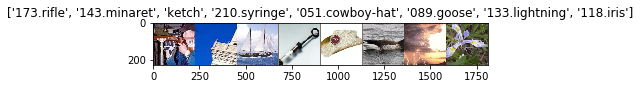

In [55]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
class_names = image_datasets['train'].classes
inputs, classes = next(iter(dataloaders_dict['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Fine tuning our model

In [37]:
!pip3 install ax-platform 

     |████████████████████████████████| 501kB 4.8MB/s 
     |████████████████████████████████| 225kB 22.4MB/s 
     |████████████████████████████████| 235kB 20.6MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.0.1-py2.py3-none-any.whl size=390441 sha256=34e475e84a442cdc548f30abbd621f739945853fe31019edc041605f93902da6
  Stored in directory: /root/.cache/pip/wheels/10/2f/7a/3328e5713d796daeec2ce8ded141d5f3837253fc3c2a5c62e0
Successfully built gpytorch


In [0]:
def train_evaluate(parameterization):
    net = train(net=model_ft, train_loader=dataloaders_dict['train'], parameters=parameterization, dtype=dtype, device=device)
    return evaluate(
        net=net,
        data_loader=dataloaders_dict['val'],
        dtype=dtype,
        device=device,
    )

For the Fine Tuning of our model , we have to calibrate the Learning Rate and the Momentum. These two are connected with each other. We give a range of their possible best values and we search for their best combination.
Furthermore , we use the weight decaying , as L2 regularisation method for our model. Through different testing ranges , we made the conclusion that big weights affect negatively our dataset. So we picked a range of smaller values.

In [61]:
import torch
import numpy as np

from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.utils.tutorials.cnn_utils import load_mnist, train, evaluate, CNN
dtype = torch.float
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-4, 1e-1], "log_scale": True},
        {"name": "momentum", "type": "range", "bounds": [0.9, 0.99]},
        {"name": "weights", "type": "range", "bounds": [1e-8, 1e-4]},
    ], 
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)

[INFO 03-09 17:07:44] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 03-09 17:07:44] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 03-09 17:07:44] ax.service.managed_loop: Running optimization trial 1...
[INFO 03-09 17:08:42] ax.service.managed_loop: Running optimization trial 2...
[INFO 03-09 17:09:40] ax.service.managed_loop: Running optimization trial 3...
[INFO 03-09 17:10:39] ax.service.managed_loop: Running optimization trial 4...
[INFO 03-09 17:11:39] ax.service.managed_loop: Running optimization trial 5...
[INFO 03-09 17:12:38] ax.service.managed_loop: Running optimization trial 6...
[INFO 03-09 17:13:38] ax.service.managed_loop: Running optimization trial 7...
[INFO 03-09 17:14:40] ax.service.managed_loop: Running optimization t

Here we see the results of our search , presenting the best values for our hyperparemeters of our model on the current dataset.

In [62]:
best_parameters

{'lr': 0.00013597539815333,
 'momentum': 0.9688396614789963,
 'weights': 5.553454805076123e-05}

# Training the Model

Here we unfreeze the last layer of our network , to adopt it to our classification problem , and we start the training based on our dataset.

In [65]:
# Send the model to GPU
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In our training session, we re-initialize our model and we use a the best parameters we found before. In the training we must care about possible overfitting. For this reason, we check the progress of our accuracy. When a range of epochs , our model has decreasing accuracy , that means that it is overfitting and we stop its training.

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(params_to_update, lr=best_parameters['lr'], momentum=best_parameters['momentum'],weight_decay=best_parameters['weights'])
model_ft, hist,best_acc = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=30)

Epoch 0/29
----------
train Loss: 3.0942 Acc: 0.4111
val Loss: 1.2772 Acc: 0.7502

Epoch 1/29
----------
train Loss: 1.7296 Acc: 0.6416
val Loss: 0.8593 Acc: 0.7876

Epoch 2/29
----------
train Loss: 1.4320 Acc: 0.6683
val Loss: 0.7471 Acc: 0.7996

Epoch 3/29
----------
train Loss: 1.2954 Acc: 0.6768
val Loss: 0.6855 Acc: 0.8011

Epoch 4/29
----------
train Loss: 1.2023 Acc: 0.6961
val Loss: 0.6594 Acc: 0.8022

Epoch 5/29
----------
train Loss: 1.1510 Acc: 0.7055
val Loss: 0.6280 Acc: 0.8082

Epoch 6/29
----------
train Loss: 1.1441 Acc: 0.6976
val Loss: 0.6178 Acc: 0.8064

Epoch 7/29
----------
train Loss: 1.1076 Acc: 0.7047
val Loss: 0.6022 Acc: 0.8064

Epoch 8/29
----------
train Loss: 1.0811 Acc: 0.7095
val Loss: 0.5960 Acc: 0.8120

Epoch 9/29
----------
train Loss: 1.0515 Acc: 0.7118
val Loss: 0.5873 Acc: 0.8169

Epoch 10/29
----------
train Loss: 1.0458 Acc: 0.7131
val Loss: 0.5902 Acc: 0.8146

Epoch 11/29
----------
train Loss: 1.0435 Acc: 0.7140
val Loss: 0.5759 Acc: 0.8225

Ep

# Testing the model on real data

In [0]:
def test_model(model, dataloaders): 

    model.eval()   # Set model to evaluate mode
    phase ='test'
    running_corrects = 0
    # Iterate over data.
    y_pred = []
    y_actu = []
    output = []
    act_inputs = []
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        y_pred.append(preds.cpu().numpy())
        y_actu.append(labels.data.cpu().numpy())
    acc = running_corrects.double() / len(dataloaders[phase].dataset)

    print('{}Acc: {:.4f}'.format(phase, acc))
    return y_actu,y_pred,acc

In [68]:
y_true, y_pred,best_acc = test_model(model_ft, dataloaders_dict)

testAcc: 0.8294


# Evaluation of our model and metrics

For the evalution of our model, we show its confusion matrix.
Scores like F1, precision and recall are presented as well.
The confusion matrix due to the many classes can not be showed properly.

In [0]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score,recall_score,roc_auc_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

#y_true = [item for sublist in y_true for item in sublist]
#y_pred = [item for sublist in y_pred for item in sublist]
cm = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cm, range(num_classes), range(num_classes))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": num_classes}) # font size

plt.show()

In [72]:
print(f1_score(y_true,y_pred,average='weighted'))
print(precision_score(y_true, y_pred, average='weighted'))
print(recall_score(y_true, y_pred, average='weighted'))

0.818607997948353
0.8265106346089071
0.8294198895027625


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



We see that our model, did quite good in the task. The image recognition of random objects is not a very hard task.For this reason we were expecting a good performance. However, due to our fine tuning and proper training , we managed to improve the "simple-case" results and get a higher accuracy percentage.

# SqueezeNet


In [73]:
model_ft, input_size = initialize_model("squeezenet", num_classes, feature_extract, use_pretrained=True)
dtype = torch.float
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-4,1e-1], "log_scale": True},
        {"name": "momentum", "type": "range", "bounds": [0.9, 0.99]},
        {"name": "weights", "type": "range", "bounds": [1e-8, 1e-4]},
    ], 
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)
best_parameters

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/checkpoints/squeezenet1_0-a815701f.pth


[INFO 03-09 17:55:32] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 03-09 17:55:32] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 03-09 17:55:32] ax.service.managed_loop: Running optimization trial 1...


[INFO 03-09 17:56:31] ax.service.managed_loop: Running optimization trial 2...
[INFO 03-09 17:57:30] ax.service.managed_loop: Running optimization trial 3...
[INFO 03-09 17:58:29] ax.service.managed_loop: Running optimization trial 4...
[INFO 03-09 17:59:28] ax.service.managed_loop: Running optimization trial 5...
[INFO 03-09 18:00:27] ax.service.managed_loop: Running optimization trial 6...
[INFO 03-09 18:01:27] ax.service.managed_loop: Running optimization trial 7...
[INFO 03-09 18:02:30] ax.service.managed_loop: Running optimization trial 8...
[INFO 03-09 18:03:31] ax.service.managed_loop: Running optimization trial 9...
[INFO 03-09 18:04:31] ax.service.managed_loop: Running optimization trial 10...
[INFO 03-09 18:05:32] ax.service.managed_loop: Running optimization trial 11...
[INFO 03-09 18:06:32] ax.service.managed_loop: Running optimization trial 12...
[INFO 03-09 18:07:32] ax.service.managed_loop: Running optimization trial 13...
[INFO 03-09 18:08:32] ax.service.managed_loop: R

{'lr': 0.0017111173483354341,
 'momentum': 0.9506335723400116,
 'weights': 2.067899208530784e-05}

In [74]:
model_ft, input_size = initialize_model("squeezenet", num_classes, feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

	 classifier.1.weight
	 classifier.1.bias


In [75]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(params_to_update, lr=best_parameters['lr'], momentum=best_parameters['momentum'],weight_decay=best_parameters['weights'])
model_ft, sq_hist,best_acc = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=30)

Epoch 0/29
----------
train Loss: 3.0111 Acc: 0.3663
val Loss: 2.1058 Acc: 0.5457

Epoch 1/29
----------
train Loss: 2.1850 Acc: 0.5101
val Loss: 1.7295 Acc: 0.6146

Epoch 2/29
----------
train Loss: 1.9015 Acc: 0.5648
val Loss: 1.5834 Acc: 0.6438

Epoch 3/29
----------
train Loss: 1.7893 Acc: 0.5892
val Loss: 1.6239 Acc: 0.6494

Epoch 4/29
----------
train Loss: 1.6714 Acc: 0.6054
val Loss: 1.5194 Acc: 0.6625

Epoch 5/29
----------
train Loss: 1.6074 Acc: 0.6223
val Loss: 1.4792 Acc: 0.6753

Epoch 6/29
----------
train Loss: 1.5735 Acc: 0.6252
val Loss: 1.4172 Acc: 0.6824

Epoch 7/29
----------
train Loss: 1.5120 Acc: 0.6376
val Loss: 1.4552 Acc: 0.6734

Epoch 8/29
----------
train Loss: 1.5041 Acc: 0.6443
val Loss: 1.3987 Acc: 0.6790

Epoch 9/29
----------
train Loss: 1.4166 Acc: 0.6569
val Loss: 1.4180 Acc: 0.6884

Epoch 10/29
----------
train Loss: 1.4004 Acc: 0.6634
val Loss: 1.4556 Acc: 0.6745

Epoch 11/29
----------
train Loss: 1.3839 Acc: 0.6630
val Loss: 1.4651 Acc: 0.6794

Ep

In [76]:
sq_y_true, sq_y_pred,sq_best_acc = test_model(model_ft, dataloaders_dict)

testAcc: 0.6678


In [77]:
sq_y_true = [item for sublist in sq_y_true for item in sublist]
sq_y_pred = [item for sublist in sq_y_pred for item in sublist]

print(f1_score(sq_y_true,sq_y_pred,average='weighted'))
print(precision_score(sq_y_true, sq_y_pred, average='weighted'))
print(recall_score(sq_y_true, sq_y_pred, average='weighted'))

0.6560826855065938
0.686335766910759
0.6678176795580111


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# Baseline Model


For our baseline model , we will use a Sequential Network with 2 layers.
We train the network on our train dataset , here we check as well , that our network does not overfit during its training.
Afterwards, we test it on our testing dataset.

In [84]:
import torch.nn.functional as F
my_net = nn.Sequential(
      torch.nn.Flatten(),
      torch.nn.Linear(224*224*3,200),
      torch.nn.ReLU(),
      torch.nn.Linear(200,200),
      torch.nn.ReLU(),
      torch.nn.Linear(200,num_classes)
    )

model_ft = my_net.to(device)
print(my_net)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=150528, out_features=200, bias=True)
  (2): ReLU()
  (3): Linear(in_features=200, out_features=200, bias=True)
  (4): ReLU()
  (5): Linear(in_features=200, out_features=115, bias=True)
)


In [85]:
dtype = torch.float
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-4,1e-1], "log_scale": True},
        {"name": "momentum", "type": "range", "bounds": [0.9, 0.99]},
        {"name": "weights", "type": "range", "bounds": [1e-8, 1e-4]},
    ], 
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)
best_parameters

[INFO 03-09 18:43:39] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 03-09 18:43:39] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 03-09 18:43:39] ax.service.managed_loop: Running optimization trial 1...
[INFO 03-09 18:44:37] ax.service.managed_loop: Running optimization trial 2...
[INFO 03-09 18:45:34] ax.service.managed_loop: Running optimization trial 3...
[INFO 03-09 18:46:31] ax.service.managed_loop: Running optimization trial 4...
[INFO 03-09 18:47:28] ax.service.managed_loop: Running optimization trial 5...
[INFO 03-09 18:48:25] ax.service.managed_loop: Running optimization trial 6...
[INFO 03-09 18:48:25] StandardizeY: Outcome accuracy is constant, within tolerance.
[INFO 03-09 18:49:23] ax.service.managed_loop: Running optimizat

{'lr': 0.0002360921394022941,
 'momentum': 0.9044699498545379,
 'weights': 9.625010619130917e-05}

In [87]:
my_net = nn.Sequential(
      torch.nn.Flatten(),
      torch.nn.Linear(224*224*3,200),
      torch.nn.ReLU(),
      torch.nn.Linear(200,200),
      torch.nn.ReLU(),
      torch.nn.Linear(200,num_classes)
    )

model_ft = my_net.to(device)
loss_fn = nn.CrossEntropyLoss()
my_net_parameters = my_net.parameters()
basic_optimizer = optim.SGD(my_net_parameters, lr=best_parameters['lr'], momentum=best_parameters['momentum'],weight_decay=best_parameters['weights'])
my_net, basic_hist,basic_best_acc = train_model(my_net, dataloaders_dict, loss_fn, basic_optimizer, num_epochs=30)

Epoch 0/29
----------
train Loss: 4.6141 Acc: 0.0416
val Loss: 4.3708 Acc: 0.0663

Epoch 1/29
----------
train Loss: 4.3961 Acc: 0.0659
val Loss: 4.2363 Acc: 0.0873

Epoch 2/29
----------
train Loss: 4.2917 Acc: 0.0814
val Loss: 4.1204 Acc: 0.1112

Epoch 3/29
----------
train Loss: 4.2394 Acc: 0.0832
val Loss: 4.0684 Acc: 0.1079

Epoch 4/29
----------
train Loss: 4.1829 Acc: 0.0934
val Loss: 4.0121 Acc: 0.1228

Epoch 5/29
----------
train Loss: 4.1477 Acc: 0.0987
val Loss: 3.9896 Acc: 0.1243

Epoch 6/29
----------
train Loss: 4.1125 Acc: 0.1046
val Loss: 3.9450 Acc: 0.1315

Epoch 7/29
----------
train Loss: 4.0780 Acc: 0.1057
val Loss: 3.9206 Acc: 0.1363

Epoch 8/29
----------
train Loss: 4.0566 Acc: 0.1075
val Loss: 3.8943 Acc: 0.1393

Epoch 9/29
----------
train Loss: 4.0464 Acc: 0.1116
val Loss: 3.8465 Acc: 0.1584

Epoch 10/29
----------
train Loss: 4.0040 Acc: 0.1185
val Loss: 3.8530 Acc: 0.1491

Epoch 11/29
----------
train Loss: 3.9865 Acc: 0.1214
val Loss: 3.8242 Acc: 0.1547

Ep

In [88]:
def test_basic_model(model, dataloaders): 

    model.eval()   # Set model to evaluate mode
    phase ='test'
    running_corrects = 0
    # Iterate over data.
    y_pred = []
    y_actu = []
    output = []
    act_inputs = []
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        y_pred.append(preds.cpu().numpy())
        y_actu.append(labels.data.cpu().numpy())
    acc = running_corrects.double() / len(dataloaders[phase].dataset)

    print('{}Acc: {:.4f}'.format(phase, acc))
    return y_actu,y_pred,acc
y_true2, y_pred2,basic_acc = test_basic_model(my_net, dataloaders_dict)

testAcc: 0.1430


# Vgg vs SqueezeNet vs Baseline Model

Here we compare the the pretrained VGG model,against the SqueezeNet and the Baseline Model.
As we can see from the below figure, the VGG presents the best performance, not only in the accuracy but in other metrics as well. SqueezeNet did better than the baseline model, but was worse than VGG.


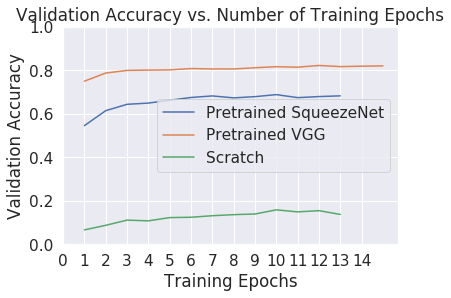

In [90]:

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,len(sq_hist)+1),sq_hist,label="Pretrained SqueezeNet")
plt.plot(range(1,len(hist)+1),hist,label="Pretrained VGG")
plt.plot(range(1,len(basic_hist)+1),basic_hist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(0,len(hist), 1.0))
plt.legend()
plt.show()

Here we can see the corresponding metrics of the baseline model.

In [94]:
y_true2 = [item for sublist in y_true2 for item in sublist]
y_pred2 = [item for sublist in y_pred2 for item in sublist]
print(f1_score(y_true2,y_pred2,average='weighted'))
print(precision_score(y_true2, y_pred2, average='weighted'))
print(recall_score(y_true2, y_pred2, average='weighted'))

0.0977781048597258
0.09443255203193957
0.14295580110497239


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# Conclusion


In conclusion, we fine-tuned our VGG model based on our dataset. We then trained it , we checked that our train did not lead to overfit, and tested on the test dataset.
We followed the same procedure for the SqueezeNet as well.
SqueezeNet showed worse performance than the VGG.
Compared to a basic 2-layer Network , also trained on the dataset , we can see that the pretrained model has better performance. His training starts from high accuracy, since it has been already pre-trained on image recogniton, in constrast to a simple network. Therefore, the training presents not so much improvement. It mostly help our model to adopt in a better way to the particular dataset of images. The simple 2-layer Network , as a result , has very low accuracy and it would need a lot more training and with a more rich training dataset , in order to reach a score near the pre-trained model.

# References




1.   Medium. (2020).Ideas on how to fine-tune a pre-trained model in PyTorch. [online] Available at: https://medium.com/udacity-pytorch-challengers/ideas-on-how-to-fine-tune-a-pre-trained-model-in-pytorch-184c47185a20. 

2.   Medium. (2020). Hyper-parameter Tuning Techniques in Deep Learning. [online] Available at: https://towardsdatascience.com/hyper-parameter-tuning-techniques-in-deep-learning-4dad592c63c8 [Accessed 8 Mar. 2020].

3. Medium. (2020). Simple Implementation of Densely Connected Convolutional Networks in PyTorch.. [online] Available at: https://towardsdatascience.com/simple-implementation-of-densely-connected-convolutional-networks-in-pytorch-3846978f2f36 [Accessed 8 Mar. 2020].

4. L. Fei-Fei, R. Fergus and P. Perona. Learning generative visual models
from few training examples: an incremental Bayesian approach tested on
101 object categories. IEEE. CVPR 2004, Workshop on Generative-Model
Based Vision. 2004

5. Pytorch.org. 2020. Finetuning Torchvision Models — Pytorch Tutorials 1.2.0 Documentation. [online] Available at: <https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html> [Accessed 9 March 2020]. 


